# Unrolling neural network training

In [6]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)

import warnings
warnings.filterwarnings("ignore")


## Toy case models and datasets

In [211]:
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape y_train to match model output shape
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape y_test to match model output shape

In [212]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-1, weight_decay = 5e-4)
criterion = nn.MSELoss()

### Simple training loop 

In [213]:
train_losses = []

for epoch in range(100):
    # Forward pass
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [10/100], Loss: 108.9392
Epoch [20/100], Loss: 43.4876
Epoch [30/100], Loss: 24.4725
Epoch [40/100], Loss: 18.0850
Epoch [50/100], Loss: 14.4142
Epoch [60/100], Loss: 12.0501
Epoch [70/100], Loss: 10.4739
Epoch [80/100], Loss: 9.5392
Epoch [90/100], Loss: 8.7902
Epoch [100/100], Loss: 8.1955
Test Loss: 12.1529


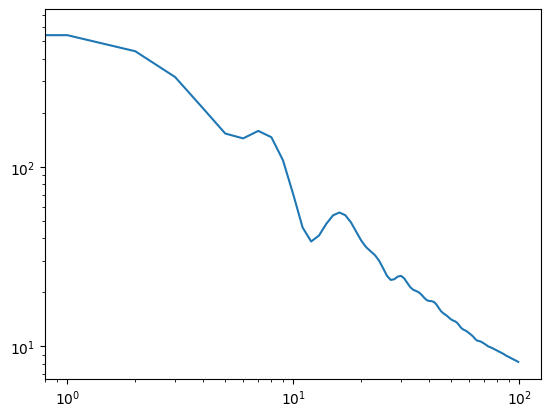

In [214]:
plt.loglog(train_losses)

### SCANTRA - DeepUnrolling SCA for Neural networks TRAining

Let's try to define a surrogate loss using a general purpose second order approximations and the gradient of the feedforward network. 

In [215]:
class SCANTRALayer(nn.Module):
    def __init__(self, model, lambda_ = 0.1, tau = 1, gamma = 0.9):
        super().__init__()

        # Initialization of the learnable parameters
        self.lambda_ = nn.Parameter(torch.ones(1)*lambda_, requires_grad = True)
        self.tau = nn.Parameter(torch.ones(1)*tau, requires_grad = True)
        self.gamma = gamma
        
        self.B = []
        for _, p in model.named_parameters():
            self.B.append(nn.Parameter(torch.randn(p.shape[0]), requires_grad = True))

        self.params = nn.ParameterList(self.B + [self.lambda_, self.tau])


    def forward(self, model):
        for i, (_, p) in enumerate(model.named_parameters()):
            K = p.grad
            print(K)
            # Local optimization step
            if len(p.shape) == 1:
                I = torch.ones(self.B[i].shape[0])
                H = self.B[i]**2 + self.tau*I
                M = 1/((2*self.lambda_ + self.tau)*I + H)
                
            else:
                I = self.tau*torch.eye(self.B[i].shape[0])
                H = torch.outer(self.B[i],self.B[i]) + self.tau*I
                M = torch.linalg.inv((2*self.lambda_ + self.tau)*I + H)

            w_hat = M @ (H @ p - K)
            #p_0 = p

            with torch.no_grad():
                p.copy_(p + self.gamma*(w_hat - p))

            #print(torch.linalg.norm(p - p_0))

In [216]:
class SCANTRANet(nn.Module):
    def __init__(self, model, T = 10, lambda_ = 0.1, tau = 25, gamma = 0.8):
        super(SCANTRANet, self).__init__()
        
        # Number of iterations <-> number of layers
        self.T = T
        
        # Initialization of the learnable parameters
        self.lambda_0 = torch.ones(T)*lambda_
        self.tau_0 = torch.ones(T)*tau
        self.gamma_0 = torch.ones(T)*gamma

        for i in range(self.T):
            self.gamma_0[i] *= 0.99**i
            
        # Defining the layers
        self.SCANTRA_layers = nn.ModuleList([SCANTRALayer(model,
                                                          self.lambda_0[i], 
                                                          self.tau_0[i], 
                                                          self.gamma_0[i]
                                                          ) for i in range(self.T)])
        
        # Optimizer of the neural optimizer
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=1e-1, weight_decay = 5e-4)
        
    def step(self, model, criterion, epoch, X_train_tensor, y_train_tensor):
        
        self.SCANTRA_layers[epoch].forward(model)
        self.source = model
        
        # Compute loss
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Zero gradients for optimizer parameters
        self.zero_grad()

        # Compute gradients of loss with respect to optimizer parameters
        loss.backward(retain_graph=True)

        # Update optimizer parameters
        self.optimizer.step()  


In [217]:
model = nn.Sequential(
    nn.Linear(13, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

criterion = nn.MSELoss()
optimizer = SCANTRANet(model, T = 100)

The problem is: how do I train at the same time the network and the optimizer? 

In [ ]:
train_losses = []

for epoch in range(1):
    # Forward pass
    model.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    
    # Our beautiful neural optimizer
    optimizer.step(model, criterion, epoch, X_train_tensor, y_train_tensor)
    #optimizer.transfer(model)
    
    # Store loss value
    train_losses.append(loss.item())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')

    # Evaluate the model on the test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        print(f'Test Loss: {test_loss.item():.4f}')


In [ ]:
plt.loglog(train_losses)

______________

In [1]:
import tensorflow as tf

import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

'''
import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float32)
'''

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the Boston dataset
boston = load_boston()
X = boston.data
y = boston.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to TensorFlow tensors
X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train, dtype=tf.float32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test, dtype=tf.float32)

# Reshape y tensors to match model output shape
y_train_tensor = tf.reshape(y_train_tensor, shape=(-1, 1))
y_test_tensor = tf.reshape(y_test_tensor, shape=(-1, 1))

In [3]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(1)
])

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1, decay=5e-4)


# Define the loss function
criterion = tf.keras.losses.MeanSquaredError()

In [4]:
train_losses = []

for epoch in range(100):
    # Forward pass
    with tf.GradientTape() as tape:
        outputs = model(X_train_tensor)
        loss = criterion(y_train_tensor, outputs)
    
    # Backward pass and optimization
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Store loss value
    train_losses.append(loss.numpy())
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.numpy():.4f}')

# Evaluate the model on the test set
test_outputs = model(X_test_tensor)
test_loss = criterion(y_test_tensor, test_outputs)
print(f'Test Loss: {test_loss.numpy():.4f}')


Epoch [10/100], Loss: 59.6706
Epoch [20/100], Loss: 35.7853
Epoch [30/100], Loss: 21.7919
Epoch [40/100], Loss: 14.4500
Epoch [50/100], Loss: 11.1501
Epoch [60/100], Loss: 9.9278
Epoch [70/100], Loss: 8.8891
Epoch [80/100], Loss: 8.0819
Epoch [90/100], Loss: 7.4705
Epoch [100/100], Loss: 6.9707
Test Loss: 14.0148


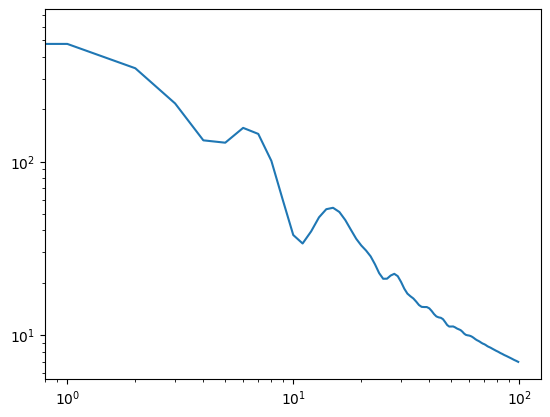

In [5]:
plt.loglog(train_losses)

In [58]:
class SCANTRALayer(tf.Module):
    def __init__(self, model, lambda_=0.1, tau=1, gamma=0.9):
        super(SCANTRALayer, self).__init__()
        self.lambda_ = tf.Variable(tf.ones(1) * lambda_, trainable=True)
        self.tau = tf.Variable(tf.ones(1) * tau, trainable=True)
        self.gamma = gamma
        
        self.B = []
        for p in model.trainable_variables:
            self.B.append(tf.Variable(tf.ones(p.shape), trainable=True))
            
    '''
    def forward(self, model, criterion, X_train_tensor, y_train_tensor):
        with tf.GradientTape(persistent=True) as tape:
            loss = criterion(model(X_train_tensor), y_train_tensor)

        for i, p in enumerate(model.trainable_variables):
            K = tape.gradient(loss, p)
            #print(p.shape)
            # Local optimization step
            if len(p.shape) == 1:
                I = tf.ones_like(self.B[i])
                H = self.B[i]**2 + self.tau*I
                M = 1/((2*self.lambda_ + self.tau)*I + H)
                w_hat = M*(H*p) - K
                
            else:
                I = self.tau * tf.eye(tf.shape(self.B[i])[0])
                H = tf.matmul(self.B[i], tf.transpose(self.B[i])) + self.tau*I
                M = tf.linalg.inv((2*self.lambda_ + self.tau)*I + H)
                w_hat = tf.linalg.matmul(M, tf.linalg.matmul(H, p) - K)

            p.assign_add(self.gamma * (w_hat - p))
    '''

In [67]:
class SCANTRANet(tf.Module):
    def __init__(self, model, T=10, lambda_=0.1, tau=25, gamma=0.8):
        super(SCANTRANet, self).__init__()
        self.T = T
        self.lambda_0 = tf.Variable(tf.ones(T) * lambda_, trainable=False)
        self.tau_0 = tf.Variable(tf.ones(T) * tau, trainable=False)
        self.gamma_0 = tf.Variable(tf.ones(T) * gamma, trainable=False)

        for i in range(self.T):
            self.gamma_0[i].assign(self.gamma_0[i] * 0.99**i)

        self.SCANTRA_layers = [SCANTRALayer(model, self.lambda_0[i], self.tau_0[i], self.gamma_0[i]) for i in range(self.T)]
        self.meta_optimizer = tf.optimizers.Adam(learning_rate=1e-1, decay=5e-4)

    @tf.function
    def step(self, model, criterion, epoch, X_train_tensor, y_train_tensor):
        layer = self.SCANTRA_layers[epoch]
        params = []
        with tf.GradientTape(persistent=True) as tape:
            loss = criterion(model(X_train_tensor), y_train_tensor)

            tape.watch(self.trainable_variables)
            for i, p in enumerate(model.trainable_variables):
                K = tape.gradient(loss, p)
                #print(p.shape)
                # Local optimization step
                if len(p.shape) == 1:
                    I = tf.ones_like(layer.B[i])
                    H = layer.B[i]**2 + layer.tau*I
                    M = 1/((2*layer.lambda_ + layer.tau)*I + H)
                    w_hat = M*((H*p) - K)
                    
                else:
                    I = layer.tau * tf.eye(tf.shape(layer.B[i])[0])
                    H = tf.matmul(layer.B[i], tf.transpose(layer.B[i])) + layer.tau*I
                    M = tf.linalg.inv((2*layer.lambda_ + layer.tau)*I + H)
                    w_hat = tf.linalg.matmul(M, tf.linalg.matmul(H, p) - K)

                p.assign_add(layer.gamma * (w_hat - p))


            #tape.watch(self.trainable_variables)
            tape.watch(model.trainable_variables)
            loss = criterion(model(X_train_tensor), y_train_tensor)
            
            '''
            tape.watch(self.trainable_variables)
            self.SCANTRA_layers[epoch].forward(model, criterion, X_train_tensor, y_train_tensor)
            outputs = model(X_train_tensor, training=True)
            loss = criterion(y_train_tensor, outputs)
            '''

        gradients = tape.gradient(loss, list(model.trainable_variables) + list(self.trainable_variables))
        optimizer_gradients = gradients[len(self.trainable_variables):]
        #tf.print(gradients)

        self.meta_optimizer.apply_gradients(zip(optimizer_gradients, self.trainable_variables))

In [68]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(13,)),
    tf.keras.layers.Dense(1)
])

# Define the loss function
criterion = tf.keras.losses.MeanSquaredError()

# Initialize the neural optimizer
optimizer = SCANTRANet(model, T = 100)

In [69]:
train_losses = []

for epoch in tqdm(range(100)):
    
    # Our beautiful neural optimizer
    optimizer.step(model, criterion, epoch, X_train_tensor, y_train_tensor)
    #optimizer.transfer(model)
    
    # Store loss value
    train_losses.append(criterion(model(X_train_tensor), y_train_tensor))
    
    '''
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')
    
    # Evaluate the model on the test set
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        #print(f'Test Loss: {test_loss.item():.4f}')
    '''

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: in user code:

    File "C:\Users\Leonardo\AppData\Local\Temp\ipykernel_15316\2371878125.py", line 57, in step  *
        self.meta_optimizer.apply_gradients(zip(optimizer_gradients, self.trainable_variables))
    File "c:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 689, in apply_gradients  **
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "c:\Users\Leonardo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\utils.py", line 77, in filter_empty_gradients
        raise ValueError(

    ValueError: No gradients provided for any variable: (['Variable:0', 'Variable:0', 'Variable:0', 'Variable:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable:0' shape=(13, 30) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(30,) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(30, 1) dtype=float32>), (None, <tf.Variable 'Variable:0' shape=(1,) dtype=float32>)).


In [ ]:
plt.loglog(train_losses)